# 2 MNIST classification

In [1]:
#2.1 Loading the MNIST dataset

import tensorflow_datasets as tfds
import tensorflow as tf
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras import optimizers

(train_ds, test_ds), ds_info = tfds.load('mnist', split=['train', 'test'], as_supervised=True, with_info=True)
#tfds.show_examples(train_ds , ds_info)


# 2.2 Setting up the data pipeline

def data_pipeline(input, batch_size=64, prefetch_buffer_size=4):
    # Map the dataset to extract images and labels
    input =input.map(lambda image, label: (image, label))
    # Reshape each image to a flat vector
    input = input.map(lambda image, label: (tf.reshape(image, (-1,)), label))
    # Normalize(Scale) image values to be in the range [-1, 1]
    input = input.map(lambda image, label: ((tf.cast(image, tf.float32) / 128) - 1, label))
    # One-hot encode the labels
    input = input.map(lambda image, label: (image, tf.one_hot(label, depth=10)))
    # Shuffle the dataset and create batches of size 4
    input = input.shuffle(1024).batch(batch_size)
    # Prefetch the dataset to improve pipeline performance
    input = input.prefetch(prefetch_buffer_size)
    return input

# Save the datasets after applying the data pipeline
train_dataset = data_pipeline(train_ds)
test_dataset = data_pipeline(test_ds)

"""
# To check the dataset after applying the data pipeline
for train_elem in train_dataset.take(1):
    print(train_elem)

for test_elem in test_dataset.take(1):
    print(test_elem)
"""

# 2.3 Building a deep neural network with TensorFlow
class MLPModel(tf.keras.Model):
    def __init__(self, layer_sizes=[256, 256], output_size=10):
        super().__init__()
        self.mlp_layers = []  # create a list to store hidden layers

        # Create hidden layers with ReLU activation
        for layer_size in layer_sizes:
            new_layer = layers.Dense(units=layer_size, activation='relu')
            self.mlp_layers.append(new_layer)
        # Output layer with softmax activation for classification
        self.output_layer = layers.Dense(units=output_size, activation='softmax')

    def call(self, x):
        # Forward pass through hidden layers
        for mlp_layer in self.mlp_layers:
            x = mlp_layer(x)
        # Forward pass through the output layer
        y = self.output_layer(x)
        return y

# 2.4 Training the network

def train_model(num_epochs, model, train_dataset, test_dataset, loss_function, optimizer, layer_sizes):
    train_losses = []
    test_losses = []
    train_accuracies = []  
    test_accuracies = []   
    
    for epoch in range(num_epochs):
        epoch_train_losses = [] #   List to store losses of each epoch
        correct_train_predictions = 0  # Counter for correct training predictions
        total_train_samples = 0 # Counter for total training samples

        # Training phase
        for x_train, target_train in train_dataset:
            with tf.GradientTape() as tape:
                # Forward pass
                pred_train = model(x_train)
                # Calculate the training loss
                loss_train = loss_function(target_train, pred_train)

            # Calculate gradients
            gradients_train = tape.gradient(loss_train, model.trainable_variables)

            # Update weights using optimizer
            optimizer.apply_gradients(zip(gradients_train, model.trainable_variables))

            # Append the training loss to the list
            epoch_train_losses.append(loss_train.numpy())

            # Calculate training accuracy
            correct_train_predictions += np.sum(np.argmax(target_train, axis=1) == np.argmax(pred_train, axis=1))
            total_train_samples += len(x_train)

        train_accuracy = correct_train_predictions / total_train_samples
        train_accuracies.append(train_accuracy)

        # Testing phase
        epoch_test_losses = []
        correct_test_predictions = 0  # Counter for correct testing predictions
        total_test_samples = 0

        for x_test, target_test in test_dataset:
            # Forward pass
            pred_test = model(x_test)
            # Calculate the testing loss
            loss_test = loss_function(target_test, pred_test)
            epoch_test_losses.append(loss_test.numpy())

            # Calculate testing accuracy
            correct_test_predictions += np.sum(np.argmax(target_test, axis=1) == np.argmax(pred_test, axis=1))
            total_test_samples += len(x_test)

        test_accuracy = correct_test_predictions / total_test_samples
        test_accuracies.append(test_accuracy)

        # Print the mean training and testing loss and accuracy for the epoch
        mean_train_loss = np.mean(epoch_train_losses)
        mean_test_loss = np.mean(epoch_test_losses)
        print(f"Epoch {epoch + 1},\n Train Loss: {mean_train_loss}, Train Accuracy: {train_accuracy},\n Test Loss: {mean_test_loss}, Test Accuracy: {test_accuracy}")

        # Append losses to the lists for visualization
        train_losses.append(mean_train_loss)
        test_losses.append(mean_test_loss)

    return train_losses, test_losses, train_accuracies, test_accuracies

# 2.5 Visualization
# We made two functions for visualisation.
# this function will be used for the basic setup to see the all the loss/accuracy in one plot
def visualization(train_losses , train_accuracies , test_losses , test_accuracies):
    plt.figure()
    line1, = plt.plot(train_losses, "b-")
    line2, = plt.plot(test_losses, "r-") 
    line3, = plt.plot(train_accuracies, "b:")
    line4, = plt.plot(test_accuracies, "r:") 
    plt.xlabel("Training steps")
    plt.ylabel("Loss/Accuracy")
    plt.legend((line1, line2, line3, line4), ("training loss", "test loss", "train accuracy", "test accuracy"))
    plt.show()
    

# this function is for plotting the results of different configurations (hyperparameters)
def plot_results(results_df):
    plt.figure(figsize=(12, 6))
    for index, row in results_df.iterrows():
        label = f"LR: {row['lr']}, Momentum: {row['momentum']}, Batch: {row['batch_size']}, Layer Sizes: {row['layer_sizes']}, Optimizers: {row['optimizer']}"
        plt.plot(row['test_losses'], label=label)
    plt.xlabel('Epochs')
    plt.ylabel('Test Loss')
    plt.title('Test Loss per Epoch for Different Configurations')
    plt.legend()
    plt.show()



Epoch 1,
 Train Loss: 0.34000876545906067, Train Accuracy: 0.8924833333333333,
 Test Loss: 0.16243593394756317, Test Accuracy: 0.949
Epoch 2,
 Train Loss: 0.14866217970848083, Train Accuracy: 0.9546166666666667,
 Test Loss: 0.14065159857273102, Test Accuracy: 0.9546
Epoch 3,
 Train Loss: 0.1123642772436142, Train Accuracy: 0.9647333333333333,
 Test Loss: 0.11692313104867935, Test Accuracy: 0.9647
Epoch 4,
 Train Loss: 0.09040089696645737, Train Accuracy: 0.9717,
 Test Loss: 0.09160767495632172, Test Accuracy: 0.9728
Epoch 5,
 Train Loss: 0.07843804359436035, Train Accuracy: 0.9748,
 Test Loss: 0.10928598046302795, Test Accuracy: 0.9681
Epoch 6,
 Train Loss: 0.06800389289855957, Train Accuracy: 0.97835,
 Test Loss: 0.10663993656635284, Test Accuracy: 0.9691
Epoch 7,
 Train Loss: 0.057240430265665054, Train Accuracy: 0.9816666666666667,
 Test Loss: 0.1605754941701889, Test Accuracy: 0.9547
Epoch 8,
 Train Loss: 0.051776617765426636, Train Accuracy: 0.98235,
 Test Loss: 0.0915428474545478

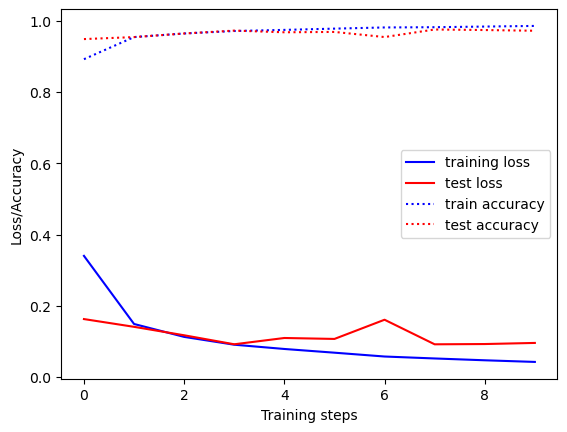

In [3]:
# Example with basic hyperparameters
EPOCHS = 10
lr = 0.1
momentum = 0.3
batch_size = 32
layer_sizes = [256, 256]
opt = optimizers.legacy.SGD

train_dataset = data_pipeline(train_ds, batch_size)
test_dataset = data_pipeline(test_ds, batch_size)

model = MLPModel(layer_sizes)

if opt == optimizers.legacy.SGD:
    optimizer = opt(learning_rate=lr, momentum=momentum)
else:
    optimizer = opt(learning_rate=lr)

cce = tf.keras.losses.CategoricalCrossentropy()

train_losses, test_losses, train_accuracies, test_accuracies = train_model(
    EPOCHS, model, train_dataset, test_dataset, cce, optimizer, layer_sizes
)


visualization(train_losses , train_accuracies , test_losses , test_accuracies)


# 3 Hyperparameter Research
We will search for the learning rate, optimizers,the number and size of layers, batch sizes and sgd momentum that give the best results. We will use test loss to evaluate the performance of the model. 


Running experiment with LR: 0.1, Momentum: 0.5, Batch Size: 32, Layer Sizes: [256, 256], Optimizer: SGD
Epoch 1,
 Train Loss: 0.4804159104824066, Train Accuracy: 0.8478,
 Test Loss: 0.20838817954063416, Test Accuracy: 0.9382
Epoch 2,
 Train Loss: 0.21678440272808075, Train Accuracy: 0.9344166666666667,
 Test Loss: 0.19449420273303986, Test Accuracy: 0.9436
Epoch 3,
 Train Loss: 0.18127693235874176, Train Accuracy: 0.9444,
 Test Loss: 0.17275771498680115, Test Accuracy: 0.9462
Epoch 4,
 Train Loss: 0.16170749068260193, Train Accuracy: 0.9514333333333334,
 Test Loss: 0.1763441115617752, Test Accuracy: 0.9513
Epoch 5,
 Train Loss: 0.1464845985174179, Train Accuracy: 0.95715,
 Test Loss: 0.14950990676879883, Test Accuracy: 0.9537
Epoch 6,
 Train Loss: 0.13633081316947937, Train Accuracy: 0.9590833333333333,
 Test Loss: 0.15284502506256104, Test Accuracy: 0.9567
Epoch 7,
 Train Loss: 0.12616872787475586, Train Accuracy: 0.9623333333333334,
 Test Loss: 0.1495673507452011, Test Accuracy: 0.95

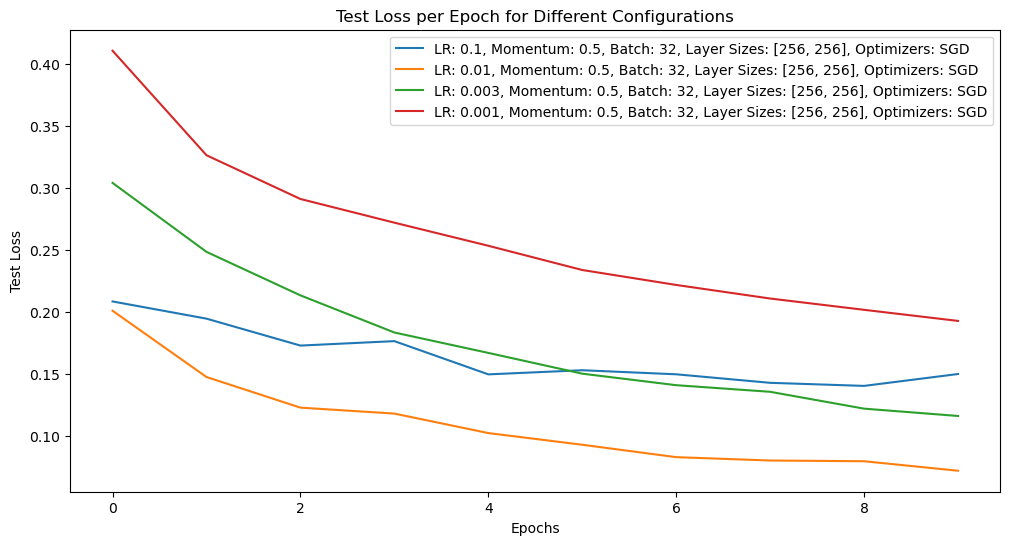

In [4]:
#1 Experiment with learning rates 
EPOCHS = 10
learning_rates = [0.1, 0.01, 0.003, 0.001]
momentums = [0.5]
batch_sizes = [32]
layer_configurations = [[256, 256]]
optimizers_list = [optimizers.legacy.SGD]

# Record results
experiment_results = []


for lr in learning_rates:
    for momentum in momentums:
        for batch_size in batch_sizes:
            for layer_sizes in layer_configurations:
                for opt in optimizers_list:
                    print(f"Running experiment with LR: {lr}, Momentum: {momentum}, Batch Size: {batch_size}, Layer Sizes: {layer_sizes}, Optimizer: {opt.__name__}")

                    train_dataset = data_pipeline(train_ds, batch_size)
                    test_dataset = data_pipeline(test_ds, batch_size)
                    
                    model = MLPModel(layer_sizes)


                    if opt == optimizers.legacy.SGD:
                        optimizer = opt(learning_rate=lr, momentum=momentum)
                    else:
                        optimizer = opt(learning_rate=lr)

                    cce = tf.keras.losses.CategoricalCrossentropy()

                    train_losses, test_losses, train_accuracies, test_accuracies = train_model(
                        EPOCHS, model, train_dataset, test_dataset, cce, optimizer, layer_sizes
                    )

                    experiment_results.append({
                        'lr': lr,
                        'momentum': momentum,
                        'batch_size': batch_size,
                        'layer_sizes': layer_sizes,
                        'optimizer': opt.__name__,
                        'train_losses': train_losses,
                        'test_losses': test_losses,
                        'train_accuracies': train_accuracies,
                        'test_accuracies': test_accuracies
                    })

results_df = pd.DataFrame(experiment_results)


print("Summary Statistics:")
print(results_df[['train_losses', 'test_losses', 'train_accuracies', 'test_accuracies']].describe())

# Best accuracy
best_accuracy = results_df.sort_values(by='test_accuracies', ascending=False).head(1)
print("\nBest Accuracy Configuration:")
print(best_accuracy)

# Lowest loss
lowest_loss = results_df.sort_values(by='test_losses').head(1)
print("\nLowest Loss Configuration:")
print(lowest_loss)

# Plotting Test Losses for different configurations
plot_results(results_df)



Running experiment with LR: 0.01, Momentum: 0.3, Batch Size: 32, Layer Sizes: [256, 256], Optimizer: SGD
Epoch 1,
 Train Loss: 0.39264115691185, Train Accuracy: 0.8849,
 Test Loss: 0.23782840371131897, Test Accuracy: 0.9305
Epoch 2,
 Train Loss: 0.20830999314785004, Train Accuracy: 0.9387166666666666,
 Test Loss: 0.18041732907295227, Test Accuracy: 0.9464
Epoch 3,
 Train Loss: 0.15653200447559357, Train Accuracy: 0.9539833333333333,
 Test Loss: 0.13796158134937286, Test Accuracy: 0.959
Epoch 4,
 Train Loss: 0.1256052851676941, Train Accuracy: 0.9631833333333333,
 Test Loss: 0.11688677221536636, Test Accuracy: 0.9649
Epoch 5,
 Train Loss: 0.10524365305900574, Train Accuracy: 0.9698166666666667,
 Test Loss: 0.10166390985250473, Test Accuracy: 0.9682
Epoch 6,
 Train Loss: 0.08973588049411774, Train Accuracy: 0.97405,
 Test Loss: 0.10371663421392441, Test Accuracy: 0.9681
Epoch 7,
 Train Loss: 0.07968590408563614, Train Accuracy: 0.9766666666666667,
 Test Loss: 0.0893469974398613, Test Acc

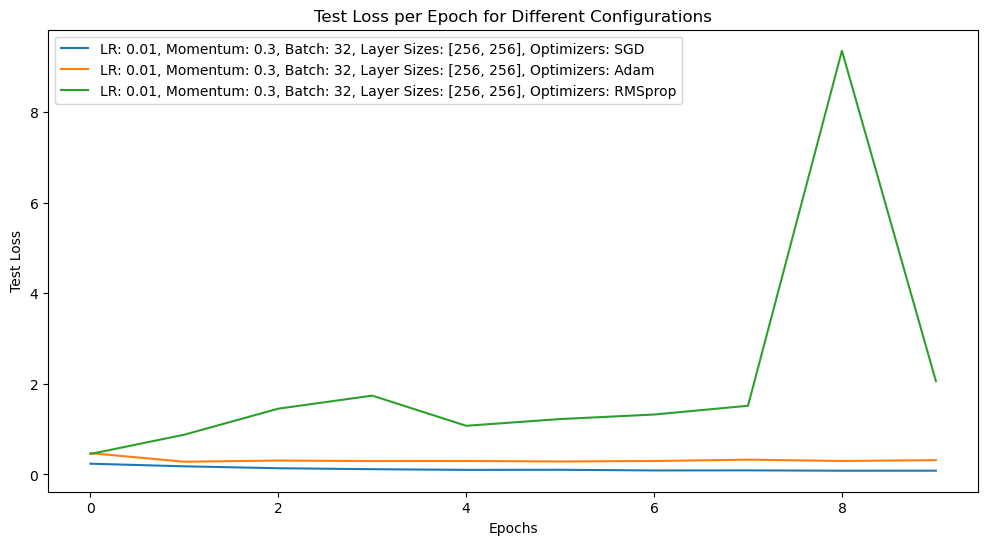

In [5]:
# 2 Experiment with Different Optimizers
EPOCHS = 10
learning_rates = [0.01] # we found the best learning rates from last experiments
momentums = [0.3]
batch_sizes = [32]
layer_configurations = [[256, 256]]
optimizers_list = [optimizers.legacy.SGD, optimizers.legacy.Adam, optimizers.legacy.RMSprop]

# Record results
experiment_results = []


for lr in learning_rates:
    for momentum in momentums:
        for batch_size in batch_sizes:
            for layer_sizes in layer_configurations:
                for opt in optimizers_list:
                    print(f"Running experiment with LR: {lr}, Momentum: {momentum}, Batch Size: {batch_size}, Layer Sizes: {layer_sizes}, Optimizer: {opt.__name__}")

                    train_dataset = data_pipeline(train_ds, batch_size)
                    test_dataset = data_pipeline(test_ds, batch_size)
                    
                    model = MLPModel(layer_sizes)


                    if opt == optimizers.legacy.SGD:
                        optimizer = opt(learning_rate=lr, momentum=momentum)
                    else:
                        optimizer = opt(learning_rate=lr)

                    cce = tf.keras.losses.CategoricalCrossentropy()

                    train_losses, test_losses, train_accuracies, test_accuracies = train_model(
                        EPOCHS, model, train_dataset, test_dataset, cce, optimizer, layer_sizes
                    )

                    experiment_results.append({
                        'lr': lr,
                        'momentum': momentum,
                        'batch_size': batch_size,
                        'layer_sizes': layer_sizes,
                        'optimizer': opt.__name__,
                        'train_losses': train_losses,
                        'test_losses': test_losses,
                        'train_accuracies': train_accuracies,
                        'test_accuracies': test_accuracies
                    })


results_df = pd.DataFrame(experiment_results)


print("Summary Statistics:")
print(results_df[['train_losses', 'test_losses', 'train_accuracies', 'test_accuracies']].describe())

# Best accuracy
best_accuracy = results_df.sort_values(by='test_accuracies', ascending=False).head(1)
print("\nBest Accuracy Configuration:")
print(best_accuracy)

# Lowest loss
lowest_loss = results_df.sort_values(by='test_losses').head(1)
print("\nLowest Loss Configuration:")
print(lowest_loss)

# Plotting Test Losses for different configurations
plot_results(results_df)



Running experiment with LR: 0.01, Momentum: 0.3, Batch Size: 32, Layer Sizes: [128, 128], Optimizer: SGD
Epoch 1,
 Train Loss: 0.41768258810043335, Train Accuracy: 0.8765166666666667,
 Test Loss: 0.24193166196346283, Test Accuracy: 0.9282
Epoch 2,
 Train Loss: 0.22129596769809723, Train Accuracy: 0.9341,
 Test Loss: 0.17459043860435486, Test Accuracy: 0.947
Epoch 3,
 Train Loss: 0.16790056228637695, Train Accuracy: 0.9502333333333334,
 Test Loss: 0.15727287530899048, Test Accuracy: 0.9514
Epoch 4,
 Train Loss: 0.13804695010185242, Train Accuracy: 0.9592833333333334,
 Test Loss: 0.1278538554906845, Test Accuracy: 0.9629
Epoch 5,
 Train Loss: 0.11767404526472092, Train Accuracy: 0.9652333333333334,
 Test Loss: 0.11354447901248932, Test Accuracy: 0.9635
Epoch 6,
 Train Loss: 0.10212144255638123, Train Accuracy: 0.9700833333333333,
 Test Loss: 0.10633867233991623, Test Accuracy: 0.9683
Epoch 7,
 Train Loss: 0.09097994118928909, Train Accuracy: 0.97295,
 Test Loss: 0.11169131100177765, Test

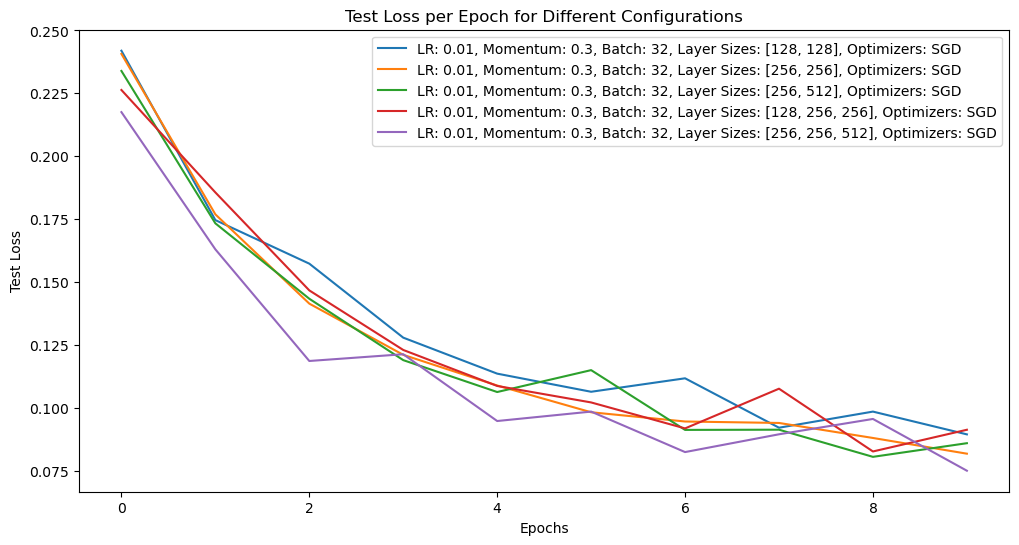

In [6]:
#3 Experiment with Different layer sizes 
EPOCHS = 10
learning_rates = [0.01] 
momentums = [0.3] 
batch_sizes = [32]
layer_configurations = [[128, 128], [256, 256], [256, 512], [128,256,256], [256, 256, 512]]
optimizers_list = [optimizers.legacy.SGD]

# Record results
experiment_results = []


for lr in learning_rates:
    for momentum in momentums:
        for batch_size in batch_sizes:
            for layer_sizes in layer_configurations:
                for opt in optimizers_list:
                    print(f"Running experiment with LR: {lr}, Momentum: {momentum}, Batch Size: {batch_size}, Layer Sizes: {layer_sizes}, Optimizer: {opt.__name__}")

                    train_dataset = data_pipeline(train_ds, batch_size)
                    test_dataset = data_pipeline(test_ds, batch_size)
                    
                    model = MLPModel(layer_sizes)


                    if opt == optimizers.legacy.SGD:
                        optimizer = opt(learning_rate=lr, momentum=momentum)
                    else:
                        optimizer = opt(learning_rate=lr)

                    cce = tf.keras.losses.CategoricalCrossentropy()

                    train_losses, test_losses, train_accuracies, test_accuracies = train_model(
                        EPOCHS, model, train_dataset, test_dataset, cce, optimizer, layer_sizes
                    )

                    experiment_results.append({
                        'lr': lr,
                        'momentum': momentum,
                        'batch_size': batch_size,
                        'layer_sizes': layer_sizes,
                        'optimizer': opt.__name__,
                        'train_losses': train_losses,
                        'test_losses': test_losses,
                        'train_accuracies': train_accuracies,
                        'test_accuracies': test_accuracies
                    })

results_df = pd.DataFrame(experiment_results)

print("Summary Statistics:")
print(results_df[['train_losses', 'test_losses', 'train_accuracies', 'test_accuracies']].describe())

# Best accuracy
best_accuracy = results_df.sort_values(by='test_accuracies', ascending=False).head(1)
print("\nBest Accuracy Configuration:")
print(best_accuracy)


# Plotting Test Losses for different configurations
plot_results(results_df)



Running experiment with LR: 0.01, Momentum: 0.5, Batch Size: 16, Layer Sizes: [256, 256], Optimizer: SGD
Epoch 1,
 Train Loss: 0.3028014898300171, Train Accuracy: 0.90815,
 Test Loss: 0.1465608775615692, Test Accuracy: 0.9548
Epoch 2,
 Train Loss: 0.1423439234495163, Train Accuracy: 0.9565333333333333,
 Test Loss: 0.1261802464723587, Test Accuracy: 0.9604
Epoch 3,
 Train Loss: 0.10209856927394867, Train Accuracy: 0.9689,
 Test Loss: 0.0961465984582901, Test Accuracy: 0.9705
Epoch 4,
 Train Loss: 0.08039966970682144, Train Accuracy: 0.9757833333333333,
 Test Loss: 0.08598952740430832, Test Accuracy: 0.9723
Epoch 5,
 Train Loss: 0.06699689477682114, Train Accuracy: 0.9796833333333334,
 Test Loss: 0.09814450144767761, Test Accuracy: 0.9686
Epoch 6,
 Train Loss: 0.05463317781686783, Train Accuracy: 0.9828166666666667,
 Test Loss: 0.07855059951543808, Test Accuracy: 0.9753
Epoch 7,
 Train Loss: 0.046558480709791183, Train Accuracy: 0.9856166666666667,
 Test Loss: 0.07215508073568344, Test A

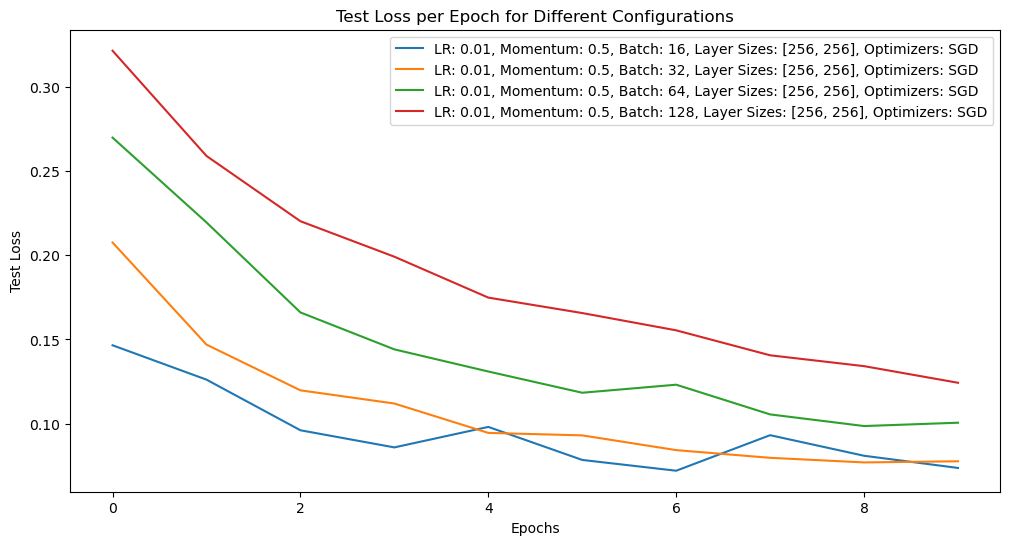

In [8]:
# 4 Experiment with different batch sizes
EPOCHS = 10
learning_rates = [0.01]
momentums = [0.5]
batch_sizes = [16, 32, 64, 128]
layer_configurations = [[256, 256]]
optimizers_list = [optimizers.legacy.SGD]

# Record results
experiment_results = []


for lr in learning_rates:
    for momentum in momentums:
        for batch_size in batch_sizes:
            for layer_sizes in layer_configurations:
                for opt in optimizers_list:
                    print(f"Running experiment with LR: {lr}, Momentum: {momentum}, Batch Size: {batch_size}, Layer Sizes: {layer_sizes}, Optimizer: {opt.__name__}")

                    train_dataset = data_pipeline(train_ds, batch_size)
                    test_dataset = data_pipeline(test_ds, batch_size)
                    
                    model = MLPModel(layer_sizes)


                    if opt == optimizers.legacy.SGD:
                        optimizer = opt(learning_rate=lr, momentum=momentum)
                    else:
                        optimizer = opt(learning_rate=lr)

                    cce = tf.keras.losses.CategoricalCrossentropy()

                    train_losses, test_losses, train_accuracies, test_accuracies = train_model(
                        EPOCHS, model, train_dataset, test_dataset, cce, optimizer, layer_sizes
                    )

                    experiment_results.append({
                        'lr': lr,
                        'momentum': momentum,
                        'batch_size': batch_size,
                        'layer_sizes': layer_sizes,
                        'optimizer': opt.__name__,
                        'train_losses': train_losses,
                        'test_losses': test_losses,
                        'train_accuracies': train_accuracies,
                        'test_accuracies': test_accuracies
                    })


results_df = pd.DataFrame(experiment_results)


print("Summary Statistics:")
print(results_df[['train_losses', 'test_losses', 'train_accuracies', 'test_accuracies']].describe())

# Best accuracy
best_accuracy = results_df.sort_values(by='test_accuracies', ascending=False).head(1)
print("\nBest Accuracy Configuration:")
print(best_accuracy)

# Lowest loss
lowest_loss = results_df.sort_values(by='test_losses').head(1)
print("\nLowest Loss Configuration:")
print(lowest_loss)

# Plotting Test Losses for different configurations
plot_results(results_df)



Running experiment with LR: 0.01, Momentum: 0.1, Batch Size: 32, Layer Sizes: [256, 256], Optimizer: SGD
Epoch 1,
 Train Loss: 0.41649746894836426, Train Accuracy: 0.8794666666666666,
 Test Loss: 0.25206559896469116, Test Accuracy: 0.9291
Epoch 2,
 Train Loss: 0.23004844784736633, Train Accuracy: 0.93285,
 Test Loss: 0.19672909379005432, Test Accuracy: 0.9402
Epoch 3,
 Train Loss: 0.17870213091373444, Train Accuracy: 0.94835,
 Test Loss: 0.16428497433662415, Test Accuracy: 0.9499
Epoch 4,
 Train Loss: 0.14674028754234314, Train Accuracy: 0.9574333333333334,
 Test Loss: 0.14581507444381714, Test Accuracy: 0.9559
Epoch 5,
 Train Loss: 0.12459198385477066, Train Accuracy: 0.96345,
 Test Loss: 0.12199816107749939, Test Accuracy: 0.963
Epoch 6,
 Train Loss: 0.10900720953941345, Train Accuracy: 0.9679,
 Test Loss: 0.11958043277263641, Test Accuracy: 0.9626
Epoch 7,
 Train Loss: 0.09572409093379974, Train Accuracy: 0.97195,
 Test Loss: 0.10454776138067245, Test Accuracy: 0.9682
Epoch 8,
 Trai

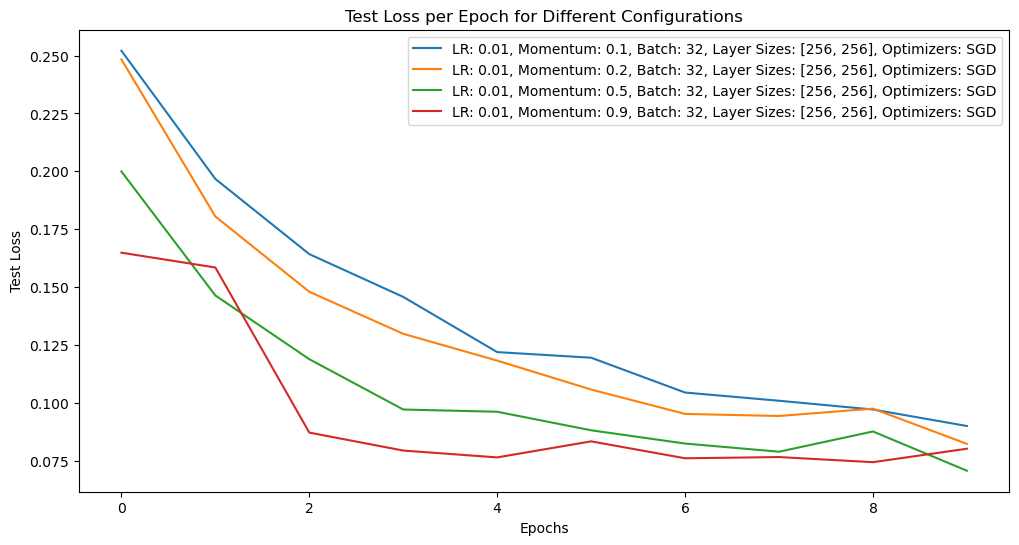

In [9]:
#5 Find the best momentum
EPOCHS = 10
learning_rates = [0.01] 
momentums = [0.1, 0.2, 0.5, 0.9]
batch_sizes = [32]
layer_configurations = [[256, 256]]
optimizers_list = [optimizers.legacy.SGD]

# Record results
experiment_results = []


for lr in learning_rates:
    for momentum in momentums:
        for batch_size in batch_sizes:
            for layer_sizes in layer_configurations:
                for opt in optimizers_list:
                    print(f"Running experiment with LR: {lr}, Momentum: {momentum}, Batch Size: {batch_size}, Layer Sizes: {layer_sizes}, Optimizer: {opt.__name__}")

                    train_dataset = data_pipeline(train_ds, batch_size)
                    test_dataset = data_pipeline(test_ds, batch_size)
                    
                    model = MLPModel(layer_sizes)


                    if opt == optimizers.legacy.SGD:
                        optimizer = opt(learning_rate=lr, momentum=momentum)
                    else:
                        optimizer = opt(learning_rate=lr)

                    cce = tf.keras.losses.CategoricalCrossentropy()

                    train_losses, test_losses, train_accuracies, test_accuracies = train_model(
                        EPOCHS, model, train_dataset, test_dataset, cce, optimizer, layer_sizes
                    )

                    experiment_results.append({
                        'lr': lr,
                        'momentum': momentum,
                        'batch_size': batch_size,
                        'layer_sizes': layer_sizes,
                        'optimizer': opt.__name__,
                        'train_losses': train_losses,
                        'test_losses': test_losses,
                        'train_accuracies': train_accuracies,
                        'test_accuracies': test_accuracies
                    })


results_df = pd.DataFrame(experiment_results)


print("Summary Statistics:")
print(results_df[['train_losses', 'test_losses', 'train_accuracies', 'test_accuracies']].describe())

# Best accuracy
best_accuracy = results_df.sort_values(by='test_accuracies', ascending=False).head(1)
print("\nBest Accuracy Configuration:")
print(best_accuracy)


# Plotting Test Losses for different configurations
plot_results(results_df)

